I want to predict if an NBA team will make the playoffs. I chose this for my first Machine Learning project because I already know which variables increase the chances of making the playoffs. I am also initerested in the power of the variables when creating the models.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt  # To visualize
plt.rcParams['figure.figsize'] = [10, 5]
import matplotlib
matplotlib.use("Qt5Agg")
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'

First, I am going to initialize some lists and variables that I will use for iteration purposes or throughout the program

In [3]:
# Variables I'll need throughout
path = "/Users/matthewmacrides/Python and R/Github/NBA Playoffs - Machine Learning/NBAPlayoffs"

sep = r'/'

seasons = ['18-19', '19-20', '20-21', '21-22', '22-23']

models = ['Random Forest', 'XGBoost']

I decided to make a for-loop in the case that I add more years of data in the future. All I will need to do is save the .csv file and update the seasons list.

In [4]:
def readData():
     # Create dataframes that will store all the years data
     Nba = pd.DataFrame()

     for season in seasons:
          Nba_ = pd.read_csv(path+sep+season+'.csv', sep=',', decimal='.')
          
          # Create a season column at the end of each file
          Nba_['Season'] = season

          # Not needed because we have win percentage
          Nba_ = Nba_.drop(columns=['Wins', 'Losses'])
          
          # Concatenate files together for each category
          Nba = pd.concat([Nba,Nba_], ignore_index=True)

          Nba.dropna(how='any', inplace=True)

          Teams = Nba[['Team', 'Season']].copy()

          
     return Nba, Teams

I was interested in the correlations across variables. To no surprise, Wins, Losses, Win Percentage, PD, and Standardized PD had strong correlations to Playoffs. I am going to include these variables in my first iteration of the modeliing. Then I am going to remove them to capture the change in accuracy. I am assuming my models will have an accuracy score close to 1 during my first iteration since the variables I mentioned are directly embedded into a team's playoff chances.

In [5]:
Nba, Teams = readData()
Nba.corr().style.background_gradient(cmap="Blues")

,Seed,Win Percentage,PD,FG%,3P%,FT%,TRB,AST,STL,BLK,TOV,PF,Age,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,Playoff,QF,SF,C
Seed,1.000000,-0.955266,-0.907568,-0.413429,-0.449803,-0.284912,-0.357051,-0.276135,-0.066169,-0.176470,0.303913,0.082533,-0.530811,0.108540,0.018050,-0.157708,-0.607603,-0.611579,0.283525,-0.108386,-0.093370,-0.859840,-0.704842,-0.424887,-0.220287
Win Percentage,-0.955266,1.000000,0.956801,0.429759,0.492888,0.289296,0.364871,0.308888,0.059602,0.207207,-0.320959,-0.090218,0.585380,-0.087164,-0.002842,0.170718,0.660299,0.661831,-0.308936,0.056612,0.114534,0.815175,0.656328,0.396235,0.217165
PD,-0.907568,0.956801,1.000000,0.406619,0.508083,0.285598,0.385998,0.322269,0.087397,0.254239,-0.326731,-0.089468,0.583993,-0.083533,0.006368,0.212697,0.673996,0.674720,-0.329642,0.090650,0.123735,0.750590,0.620100,0.390216,0.207743
FG%,-0.413429,0.429759,0.406619,1.000000,-0.042933,0.268809,-0.049736,0.438948,-0.108041,0.055326,-0.034495,-0.115943,0.285548,0.026125,0.035980,-0.160623,0.599523,0.598982,-0.030748,-0.084794,0.137555,0.329774,0.306808,0.194728,0.126432
3P%,-0.449803,0.492888,0.508083,-0.042933,1.000000,0.287064,0.027168,0.206368,-0.112933,0.010138,-0.201252,-0.194409,0.443417,-0.146095,-0.088313,0.212545,0.594610,0.608741,-0.130457,-0.080784,0.024683,0.377987,0.232063,0.162629,0.056596
FT%,-0.284912,0.289296,0.285598,0.268809,0.287064,1.000000,-0.293601,0.042070,-0.137763,-0.116608,-0.392231,-0.157336,0.176423,-0.226895,-0.131292,0.035902,0.458146,0.331504,-0.290433,-0.232868,0.248354,0.270594,0.302646,0.216329,-0.053896
TRB,-0.357051,0.364871,0.385998,-0.049736,0.027168,-0.293601,1.000000,0.090979,-0.062930,0.281654,0.066393,0.024222,0.107631,0.335243,0.012540,0.003927,-0.086076,-0.037828,-0.063939,0.399972,-0.104572,0.291913,0.281710,0.188043,0.138522
AST,-0.276135,0.308888,0.322269,0.438948,0.206368,0.042070,0.090979,1.000000,0.180551,0.149476,0.177346,-0.019539,0.125745,0.216385,-0.230352,-0.002870,0.412200,0.484859,0.098277,0.051963,-0.203166,0.114127,0.220577,0.124743,0.099913
STL,-0.066169,0.059602,0.087397,-0.108041,-0.112933,-0.137763,-0.062930,0.180551,1.000000,0.285208,0.079606,0.124383,-0.133923,0.198683,-0.099915,-0.083493,-0.192611,-0.165242,-0.030711,0.170867,-0.146701,-0.055904,0.088851,0.030273,0.186226
BLK,-0.176470,0.207207,0.254239,0.055326,0.010138,-0.116608,0.281654,0.149476,0.285208,1.000000,-0.026182,0.013781,0.094874,0.283915,-0.002282,-0.032342,0.009374,0.034442,-0.174339,0.039806,-0.050280,0.113234,0.083515,0.065364,0.103196


Making sure all the seasons are being accounted for

In [6]:
Nba['Season'].unique()

array(['18-19', '19-20', '20-21', '21-22', '22-23'], dtype=object)

I remove all string columns and additional columns that aren't important for this analysis

In [7]:
Nba = Nba.drop(columns=['Team', 'QF', 'SF', 'F', 'C'])

Data prep step to split x and y variables

In [8]:
y = Nba[["Playoff", "Season"]]
x = Nba.drop('Playoff', axis=1)
Round = "Playoff"

Here, I define a function called 'modeling' to split test and training data. I will chose Playoff as my y value. Playoff will be denoted as a '1' if the team made it and a '0' otherwise. Then I iterated through different models and recorded the accuracy for all of them.

In [9]:
def modeling(models, x, y, Round):
    # Create x and y datasets with the target variable 'Playoff' in mind. 0 denotes a team does not make the playoffs. 1 denotes that a team does make the playoffs.
    for season in seasons:

        # Separating training and testing data
        season_test = season

        x_train = x[x['Season']!=season_test]
        x_test = x[x['Season']==season_test]
        y_train = y[y['Season']!=season_test]
        y_test = y[y['Season']==season_test]


    datasets = [x_train, x_test, y_train, y_test]
    for dataset in datasets:
        dataset.drop(['Season'], axis=1, inplace=True)

    feature_list = list(x_train.columns)
    
    metric = pd.DataFrame()
    compare = pd.DataFrame()
    features = pd.DataFrame()
    
    for model in models:
            if model == 'Decision Tree':
                model_ = DecisionTreeClassifier()
            elif model == 'Random Forest':
                model_ = RandomForestClassifier()
            elif model == 'XGBoost':
                model_ = XGBClassifier()
     
            
            model_.fit(x_train, y_train.values.ravel())
            y_pred = model_.predict(x_test)

            # Store the accuracy in a dataframe. Concatenate for each accuracy score and record the model that received the result
            accuracy = metrics.accuracy_score(y_test, y_pred)
            data = {'Accuracy Score': [accuracy], 'Model': [model]}
            accuracy = pd.DataFrame(data)
            metric = pd.concat([metric,accuracy], ignore_index=True)
        

            # Find probabilities
            probability = model_.predict_proba(x_test)
            probability = probability[:, 1]

            # Comparing real vs. expected playoffs
            if Round == "Playoff": compare['Playoff'] = y_test
            if Round == "Playoff": compare['Pred Playoff ' + model] = y_pred
            if Round == "QF": compare['QF'] = y_test
            if Round == "QF": compare['Pred QF ' + model] = y_pred
            if Round == "SF": compare['SF'] = y_test
            if Round == "SF": compare['Pred SF ' + model] = y_pred
            if Round == "C": compare['C'] = y_test
            if Round == "C": compare['Pred C ' + model] = y_pred
            compare['Probability ' + model] = probability

            # Store the variable importances
            # Get numerical feature importances
            importances = list(model_.feature_importances_)
            # List of tuples with variable and importance
            feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
            # Sort the feature importances by most important first
            feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
            features_ = pd.DataFrame(feature_importances, columns=['Variables', 'Importance'])
            features_['Model'] = model
            features_ = features_.head(3)
            features = pd.concat([features, features_], ignore_index=True)
            
    return metric, compare, features

As we can see, the models are almost 100% accurate when predicting the playoff teams. The only reason they aren't 100% is because there are years that non-playoff teams in the west have a better record than playoff teams in the east and vice versa.

In [10]:
metric, compare, features = modeling(models, x, y, Round)
metric

,Accuracy Score,Model
0,0.966667,Random Forest
1,1.000000,XGBoost


Displays a list of the top 3 most important features for each model

In [11]:
features

,Variables,Importance,Model
0,Seed,0.31,Random Forest
1,Win Percentage,0.18,Random Forest
2,PD,0.16,Random Forest
3,Seed,0.51,XGBoost
4,Win Percentage,0.23,XGBoost
5,PD,0.05,XGBoost


Thiis is just showing the team, if they made the playoffs, and what the models predicted.

In [12]:
compare = pd.merge(Teams, compare, left_index=True, right_index=True)
compare

,Team,Season,Playoff,Pred Playoff Random Forest,Probability Random Forest,Pred Playoff XGBoost,Probability XGBoost
120,Milwaukee Bucks,22-23,1.0,1.0,1.00,1,0.997904
121,Boston Celtics,22-23,1.0,1.0,1.00,1,0.994823
122,Philadelphia 76ers,22-23,1.0,1.0,0.98,1,0.978847
123,Denver Nuggets,22-23,1.0,1.0,0.95,1,0.984011
124,Cleveland Cavaliers,22-23,1.0,1.0,0.97,1,0.967689
125,Memphis Grizzlies,22-23,1.0,1.0,0.94,1,0.989666
126,Sacramento Kings,22-23,1.0,1.0,0.94,1,0.951846
127,New York Knicks,22-23,1.0,1.0,0.95,1,0.982958
128,Phoenix Suns,22-23,1.0,1.0,0.97,1,0.988910
129,Brooklyn Nets,22-23,1.0,1.0,0.95,1,0.976883


Let's do the same iteration, just removing variables that directly influence whether a team makes the playoffs or not. I want to see how accurate the models can be without this information

In [13]:
NbaSmall, Teams = readData()
NbaSmall = NbaSmall.drop(columns=['Win Percentage', 'PD', 'Seed', 'Team', 'QF', 'SF', 'F', 'C'])
y = NbaSmall[["Playoff", "Season"]]
x = NbaSmall.drop('Playoff', axis=1)

In [14]:
metric, compare, features = modeling(models, x, y, Round)
metric

,Accuracy Score,Model
0,0.733333,Random Forest
1,0.733333,XGBoost


In [15]:
features

,Variables,Importance,Model
0,TS%,0.15,Random Forest
1,3P%,0.09,Random Forest
2,TRB,0.09,Random Forest
3,TS%,0.27,XGBoost
4,3P%,0.09,XGBoost
5,ORB%,0.08,XGBoost


In [16]:
compare = pd.merge(Teams, compare, left_index=True, right_index=True)
compare

,Team,Season,Playoff,Pred Playoff Random Forest,Probability Random Forest,Pred Playoff XGBoost,Probability XGBoost
120,Milwaukee Bucks,22-23,1.0,1.0,0.92,1,0.914827
121,Boston Celtics,22-23,1.0,1.0,0.94,1,0.998825
122,Philadelphia 76ers,22-23,1.0,1.0,0.86,1,0.960897
123,Denver Nuggets,22-23,1.0,1.0,0.74,1,0.650013
124,Cleveland Cavaliers,22-23,1.0,1.0,0.68,0,0.272644
125,Memphis Grizzlies,22-23,1.0,1.0,0.70,1,0.846259
126,Sacramento Kings,22-23,1.0,0.0,0.48,0,0.024658
127,New York Knicks,22-23,1.0,1.0,0.80,1,0.989030
128,Phoenix Suns,22-23,1.0,1.0,0.90,1,0.995383
129,Brooklyn Nets,22-23,1.0,1.0,0.74,1,0.954033


Lets now predict whether a playoff team will make the second round

In [17]:
Nba, Teams = readData()
NbaQF = Nba[Nba['Playoff'] == 1]
NbaQF = NbaQF.drop(columns=['Team', 'Playoff', 'SF', 'F', 'C'])
y = NbaQF[["QF", "Season"]]
x = NbaQF.drop('QF', axis=1)
Round = 'QF'

As you can see, accuracy is very very low. I go into the reasons why in the powerpoint

In [18]:
metric, compare, features = modeling(models, x, y, Round)
metric

,Accuracy Score,Model
0,0.4375,Random Forest
1,0.4375,XGBoost


In [19]:
features

,Variables,Importance,Model
0,Seed,0.23,Random Forest
1,Win Percentage,0.19,Random Forest
2,PD,0.19,Random Forest
3,Win Percentage,0.45,XGBoost
4,Seed,0.25,XGBoost
5,FT/FGA,0.09,XGBoost


In [20]:
compare = pd.merge(Teams, compare, left_index=True, right_index=True)
compare

,Team,Season,QF,Pred QF Random Forest,Probability Random Forest,Pred QF XGBoost,Probability XGBoost
120,Milwaukee Bucks,22-23,0.0,1.0,0.91,1,0.987510
121,Boston Celtics,22-23,1.0,1.0,0.92,1,0.990948
122,Philadelphia 76ers,22-23,1.0,1.0,0.97,1,0.994593
123,Denver Nuggets,22-23,1.0,1.0,0.91,1,0.992067
124,Cleveland Cavaliers,22-23,0.0,1.0,0.83,1,0.990453
125,Memphis Grizzlies,22-23,0.0,1.0,0.90,1,0.978054
126,Sacramento Kings,22-23,0.0,1.0,0.58,1,0.938067
127,New York Knicks,22-23,1.0,0.0,0.33,0,0.126271
128,Phoenix Suns,22-23,1.0,0.0,0.41,0,0.173233
129,Brooklyn Nets,22-23,0.0,0.0,0.18,0,0.017528


Let's pivot into looking at correlations between our variables. Our initial correlation graph showed that 'Age' had some positive correlations. Let's look at Age again. As you can see, Age ~ Win Percentage have a 0.59 correlation and Age ~ TS% have a 0.56 correlation.

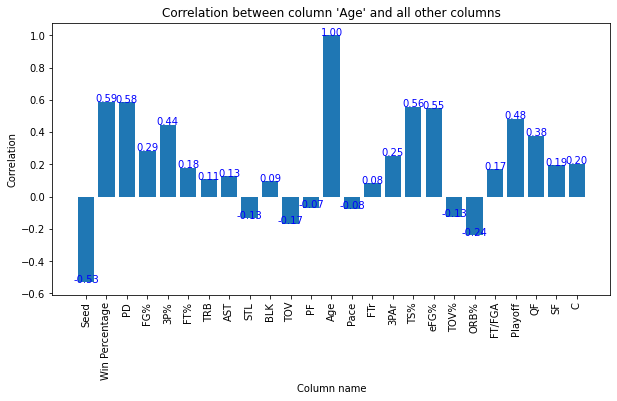

In [21]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
corr = Nba.corrwith(Nba['Age'])
plt.bar(corr.index, corr.values)
plt.title("Correlation between column 'Age' and all other columns")
plt.xlabel('Column name')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
# Add data labels to the bar chart
for i, v in enumerate(corr.values):
    plt.text(i, v, "{:.2f}".format(v), color='blue', ha='center')
plt.show()

Let's plot these two variable sets

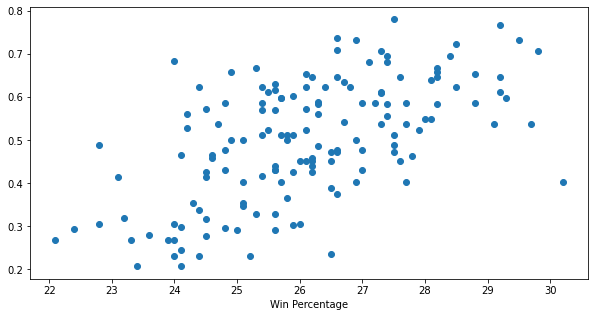

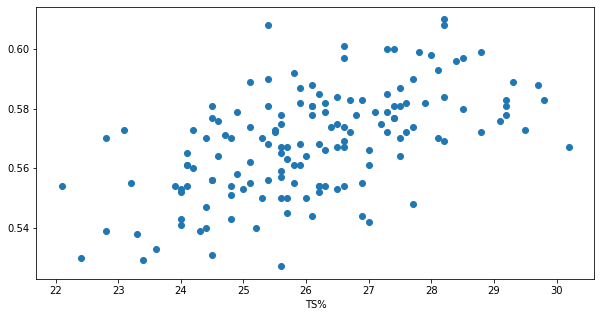

In [22]:
plt.scatter(Nba['Age'], Nba['Win Percentage'])
plt.xlabel('Win Percentage')
plt.show()
plt.scatter(Nba['Age'], Nba['TS%'])
plt.xlabel('TS%')
plt.show()

Now let's investigate whether there is statistical significance between these variables.

In [23]:
x = Nba[['Age']]
y = Nba['Win Percentage']

# Fit a linear regression model
model = LinearRegression().fit(x, y)

# Print the R-squared and p-values
r_squared = model.score(x, y)
#p_values = [model.coef_, model.intercept_]
p_values = model.coef_
print("Age ~ Win Percentage")
print("R-squared:", r_squared)
print("p-value:", p_values)
print("")

x = Nba[['Age']]
y = Nba['TS%']

# Fit a linear regression model
model = LinearRegression().fit(x, y)

# Print the R-squared and p-values
r_squared = model.score(x, y)
#p_values = [model.coef_, model.intercept_]
p_values = model.coef_
print("Age ~ TS%")
print("R-squared:", r_squared)
print("p-value:", p_values)

Age ~ Win Percentage
R-squared: 0.3426699613358246
p-value: [0.04955549]

Age ~ TS%
R-squared: 0.3117106219912412
p-value: [0.00599954]


Age has a statistically significant relationship with both Win Percentage and TS%. The R^2 is okay at around 0.31-0.34.

Average Age: Making vs. Missing Playoffs - Bar Chart

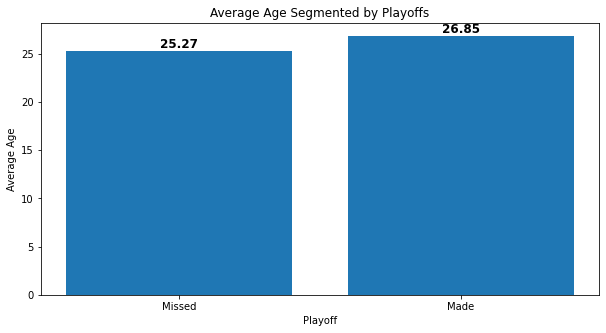

In [40]:
AgeMissed = Nba.loc[Nba['Playoff'] == 0, 'Age'].mean()
AgeMade = Nba.loc[Nba['Playoff'] == 1, 'Age'].mean()
Segment = ['Missed', 'Made']
avg_ages = [AgeMissed, AgeMade]
plt.bar(Segment, avg_ages)
plt.xlabel('Playoff')
plt.ylabel('Average Age')
plt.title('Average Age Segmented by Playoffs')
# Adding data labels to the bar chart
for i, age in enumerate(avg_ages):
    plt.text(i, age, str(round(age, 2)), ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.show()


Average Age: Making vs. Missing Playoffs - Line Graph Over the Years

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


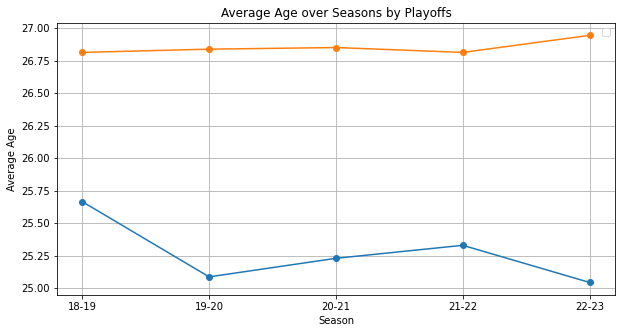

In [46]:
#Calculate the average age over time for both groups
AgeMissed = Nba[Nba['Playoff'] == 0].groupby('Season')['Age'].mean()
AgeMade = Nba[Nba['Playoff'] == 1].groupby('Season')['Age'].mean()
plt.plot(AgeMissed.index, AgeMissed.values, marker='o')
plt.plot(AgeMade.index, AgeMade.values, marker='o')
plt.xlabel('Season')
plt.ylabel('Average Age')
plt.title('Average Age over Seasons by Playoffs')
plt.legend()
plt.grid(True)
plt.show()

3PT% Over the Years

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


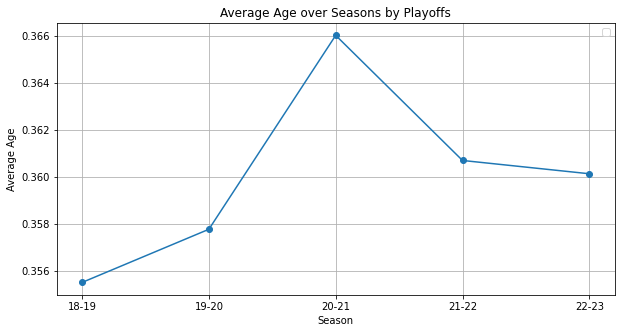

In [48]:
#Calculate the average age over time for both groups
Three = Nba.groupby('Season')['3P%'].mean()
plt.plot(Three.index, Three.values, marker='o')
plt.xlabel('Season')
plt.ylabel('Average Age')
plt.title('Average Age over Seasons by Playoffs')
plt.legend()
plt.grid(True)
plt.show()